# CWFS vignette analysis

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: 2024-01-11 <br>
Software Versions:
  - `ts_wep`: **v8.1.0**
  - `ts_imsim`: **v0.10.0**
  - `imSim`: **v2.0**

## Notebook Objective:

In this notebook we will analyze the effects of vignetting on WEP Zernike Estimation and the convergence of the AOS closed loop. At the end we will establish a limit on the distance from the center of the LSSTCam focal plane for sources we will use in the WEP pipeline.

This notebook is an updated version that replaces Phosim with imSim.

## Logistics

This notebook is intended to be run on the USDF. The data set is on the USDF at `/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/vignette_tests`. 

The data was created by running the `ts_imsim` closed loop with a single extra-focal donut at the center of the extra-focal detector and a single intra-focal donut at a specified distance from the center of the focal plane ranging from 1.7297 degrees to 1.8351 degrees from the center of the LSSTCam focal plane. Background and atmospheric effects were included. Background subtraction was performed as part of the WEP pipeline. Catalogs used for each closed loop can be found in `/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/vignette_tests/catalogs`.

Example closed loop command: 
```bash
img_closed_loop.py --output closed_loop_tests/vignette_tests/single_donut_1.7297/ --iter_num 10 --config_pointer_file ts_imsim/policy/config/lsstCamLargePertPoin
ter.yaml --sky_file catalogs/vignette_tests/single_donut_1.7297.csv --clobber --num_proc 8 
```

In [1]:
import os
import yaml
from lsst.daf.butler import Butler

from lsst.ts.wep.cwfs import Instrument
from lsst.ts.wep.utils import runProgram, writePipetaskCmd, getConfigDir, CamType
from lsst.ts.wep.task import DonutStamps
from lsst.ts.wep.task import CalcZernikesTask, CalcZernikesTaskConfig
from lsst.ts.wep.utils import ConvertZernikesToPsfWidth

import numpy as np
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt

from IPython.display import Image
from scipy.ndimage import rotate
%matplotlib inline

## Progression of vignetting across the intra-focal detectors

In addition to the closed loop tests described above we performed a simulation with intra-focal donuts at a series of different distance from the center of the LSSTCam focal plane to show the degree of vignetting as you move towards the edge of the focal plane. This dataset is in the same folder as the closed loop tests in the `single_donut_all` directory. The images were ingested and the WEP pipeline run on the images shown below. In each image the center of the focal plane is in the direction of the top right corner of the detector and as sources are simulated closer to the bottom left corner the amount of vignetting increases.

In [2]:
# Repository with simulated data
supporting_data_folder = '/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/vignette_tests'
butler_repo = os.path.join(supporting_data_folder, 'single_donut_all', 'imsimData')
# Initialize the butler
butler = Butler(butler_repo)
registry = butler.registry

In [3]:
# Specify the data Ids
extraDataIds = {}
intraDataIds = {}
extraDetectorIds = [191, 195, 199, 203]
for extraDetectorNum in extraDetectorIds:
    intraDetectorNum = extraDetectorNum + 1
    dataIdExtra = {'instrument': 'LSSTCam', 'detector': extraDetectorNum, 'exposure': 5023062001000, 'visit': 5023062001000}
    dataIdIntra = {'instrument': 'LSSTCam', 'detector': intraDetectorNum, 'exposure': 5023062001000, 'visit': 5023062001000}
    extraDataIds[str(extraDetectorNum)] = dataIdExtra
    intraDataIds[str(intraDetectorNum)] = dataIdIntra

Here we show them across the detector.

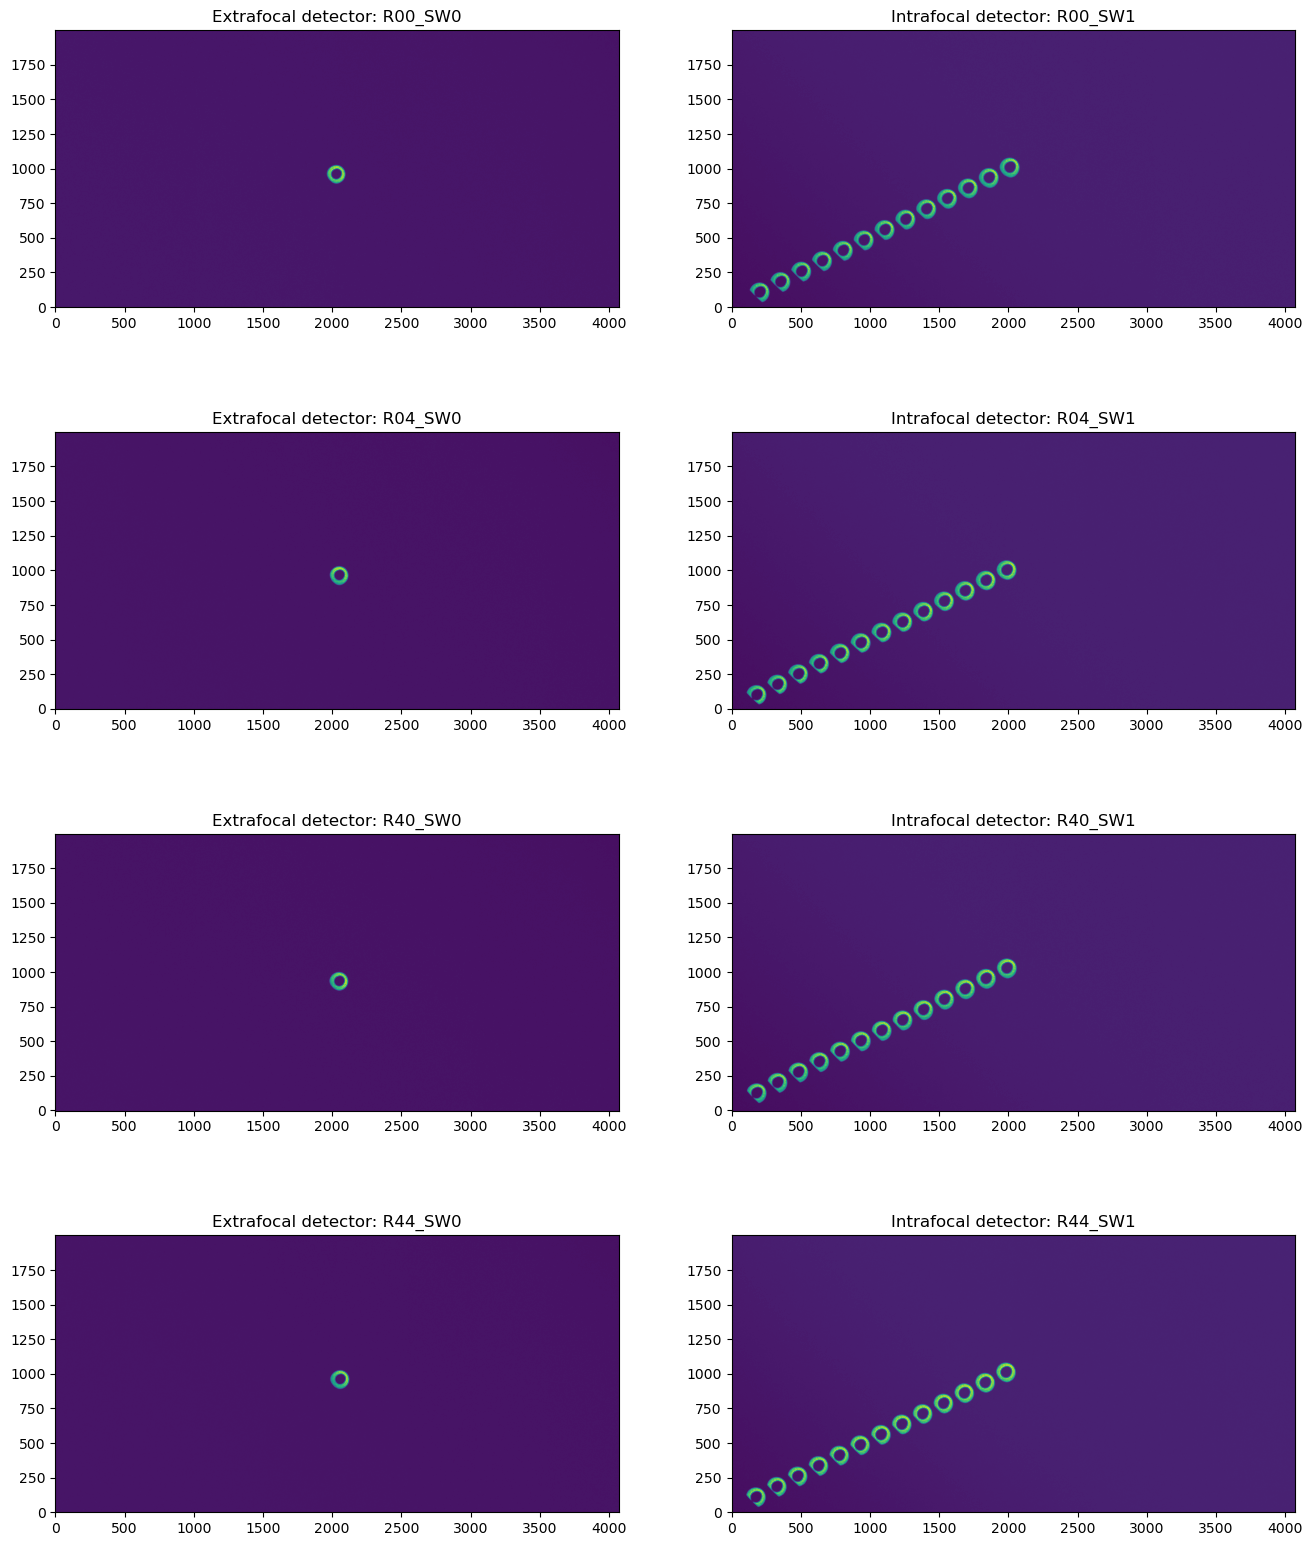

In [4]:
fig = plt.figure(figsize=(16, 20))
i = 1
for extraId in extraDetectorIds:
    fig.add_subplot(4, 2, i)
    extraIm = butler.get('postISRCCD', dataId=extraDataIds[str(extraId)], collections=['ts_imsim_1000'])
    plt.imshow(extraIm.getImage().getArray())
    extraDetectorName = extraIm.getDetector().getName()
    plt.title(f'Extrafocal detector: {extraDetectorName}')
    fig.add_subplot(4, 2, i+1)
    intraIm = butler.get('postISRCCD', dataId=intraDataIds[str(extraId+1)], collections=['ts_imsim_1000'])
    plt.imshow(intraIm.getImage().getArray())
    intraDetectorName = intraIm.getDetector().getName()
    plt.title(f'Intrafocal detector: {intraDetectorName}')
    i += 2

Let's take a closer look at the donuts by loading the `DonutStamps` for one of the detectors.

In [5]:
donutStampsIntra = butler.get('donutStampsIntra', dataId=dataIdExtra, collections=['ts_imsim_1000'])

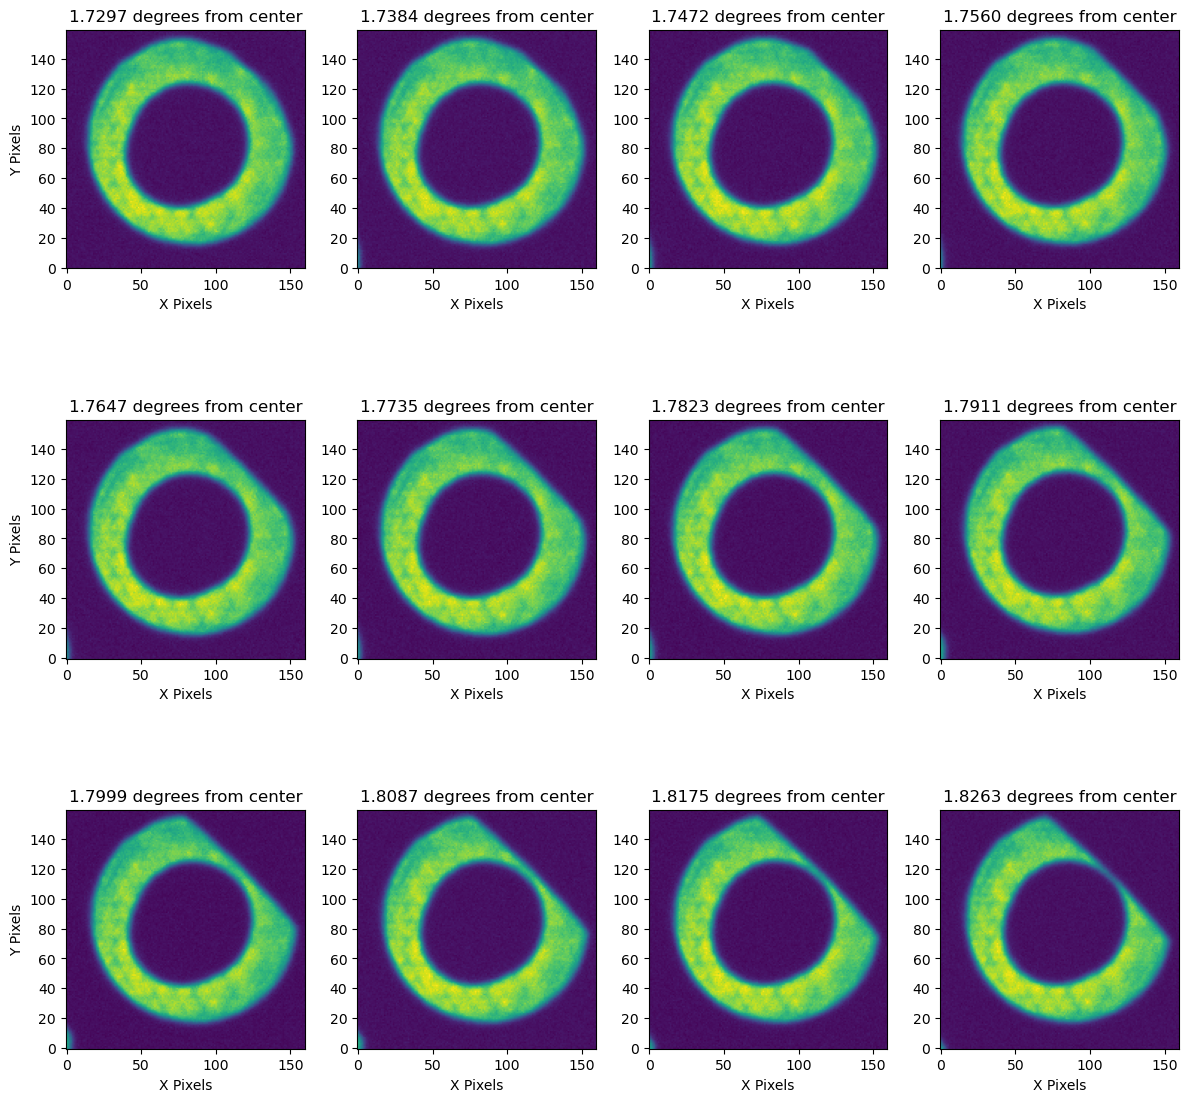

In [6]:
fig = plt.figure(figsize=(12, 12))
distToCenterVals = []
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    dStamp = donutStampsIntra[i]
    plt.imshow(dStamp.stamp_im.getImage().getArray())
    ra = dStamp.sky_position[0].asDegrees()
    dec = dStamp.sky_position[1].asDegrees()
    distToCenter = np.sqrt((ra)**2 + dec**2)
    distToCenterVals.append(distToCenter)
    plt.title(f'{distToCenter:.4f} degrees from center')
    plt.xlabel('X Pixels')
    if i in [0, 4, 8]:
        plt.ylabel('Y Pixels')
plt.tight_layout()

Finally, we show the masks that are used in the closed loop and display that the existing model adds vignetting when calculating the masks.

In [7]:
instDataPath = os.path.join(getConfigDir(), 'cwfs', 'instData')
maskDataPath = os.path.join(instDataPath, 'lsst', 'maskMigrate.yaml')
inst = Instrument()
inst.configFromFile(160, CamType.LsstCam, maskConfigFile=maskDataPath)

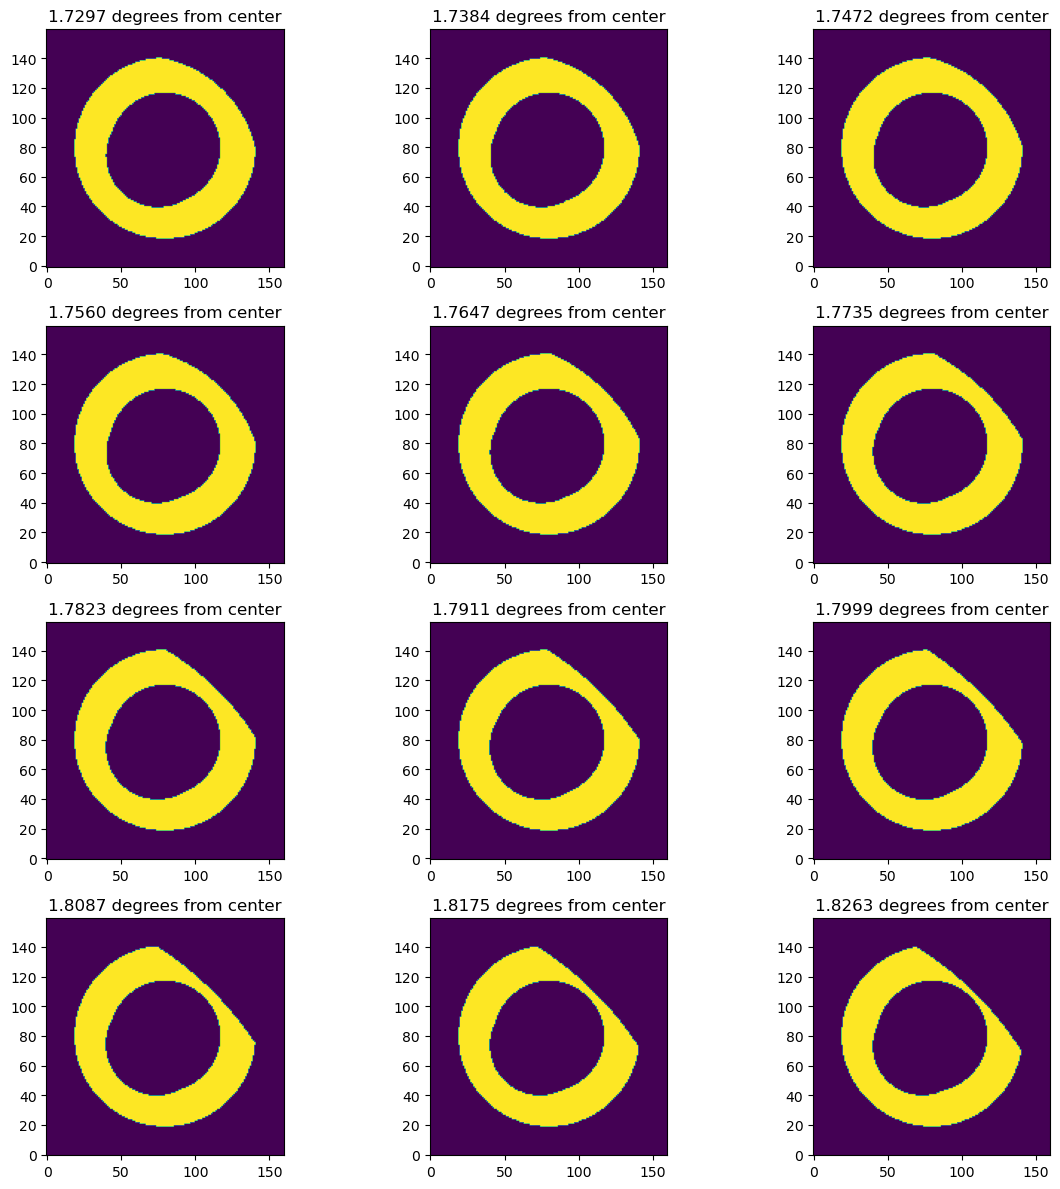

In [8]:
fig = plt.figure(figsize=(12, 12))
distToCenterVals = []
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    dStamp = donutStampsIntra[i]
    dStamp.makeMasks(inst, 'offAxis', 0, 1)
    plt.imshow(dStamp.mask_comp.getArray())
    ra = donutStampsIntra[i].sky_position[0].asDegrees()
    dec = donutStampsIntra[i].sky_position[1].asDegrees()
    distToCenter = np.sqrt((ra)**2 + dec**2)
    distToCenterVals.append(distToCenter)
    plt.title(f'{distToCenter:.4f} degrees from center')
plt.tight_layout()

A demonstration using he new mask model in `ts_wep` shows the elements of the Rubin system that contribute to the shape of the mask model we see above at 1.76 degrees from the center of the focal plane.

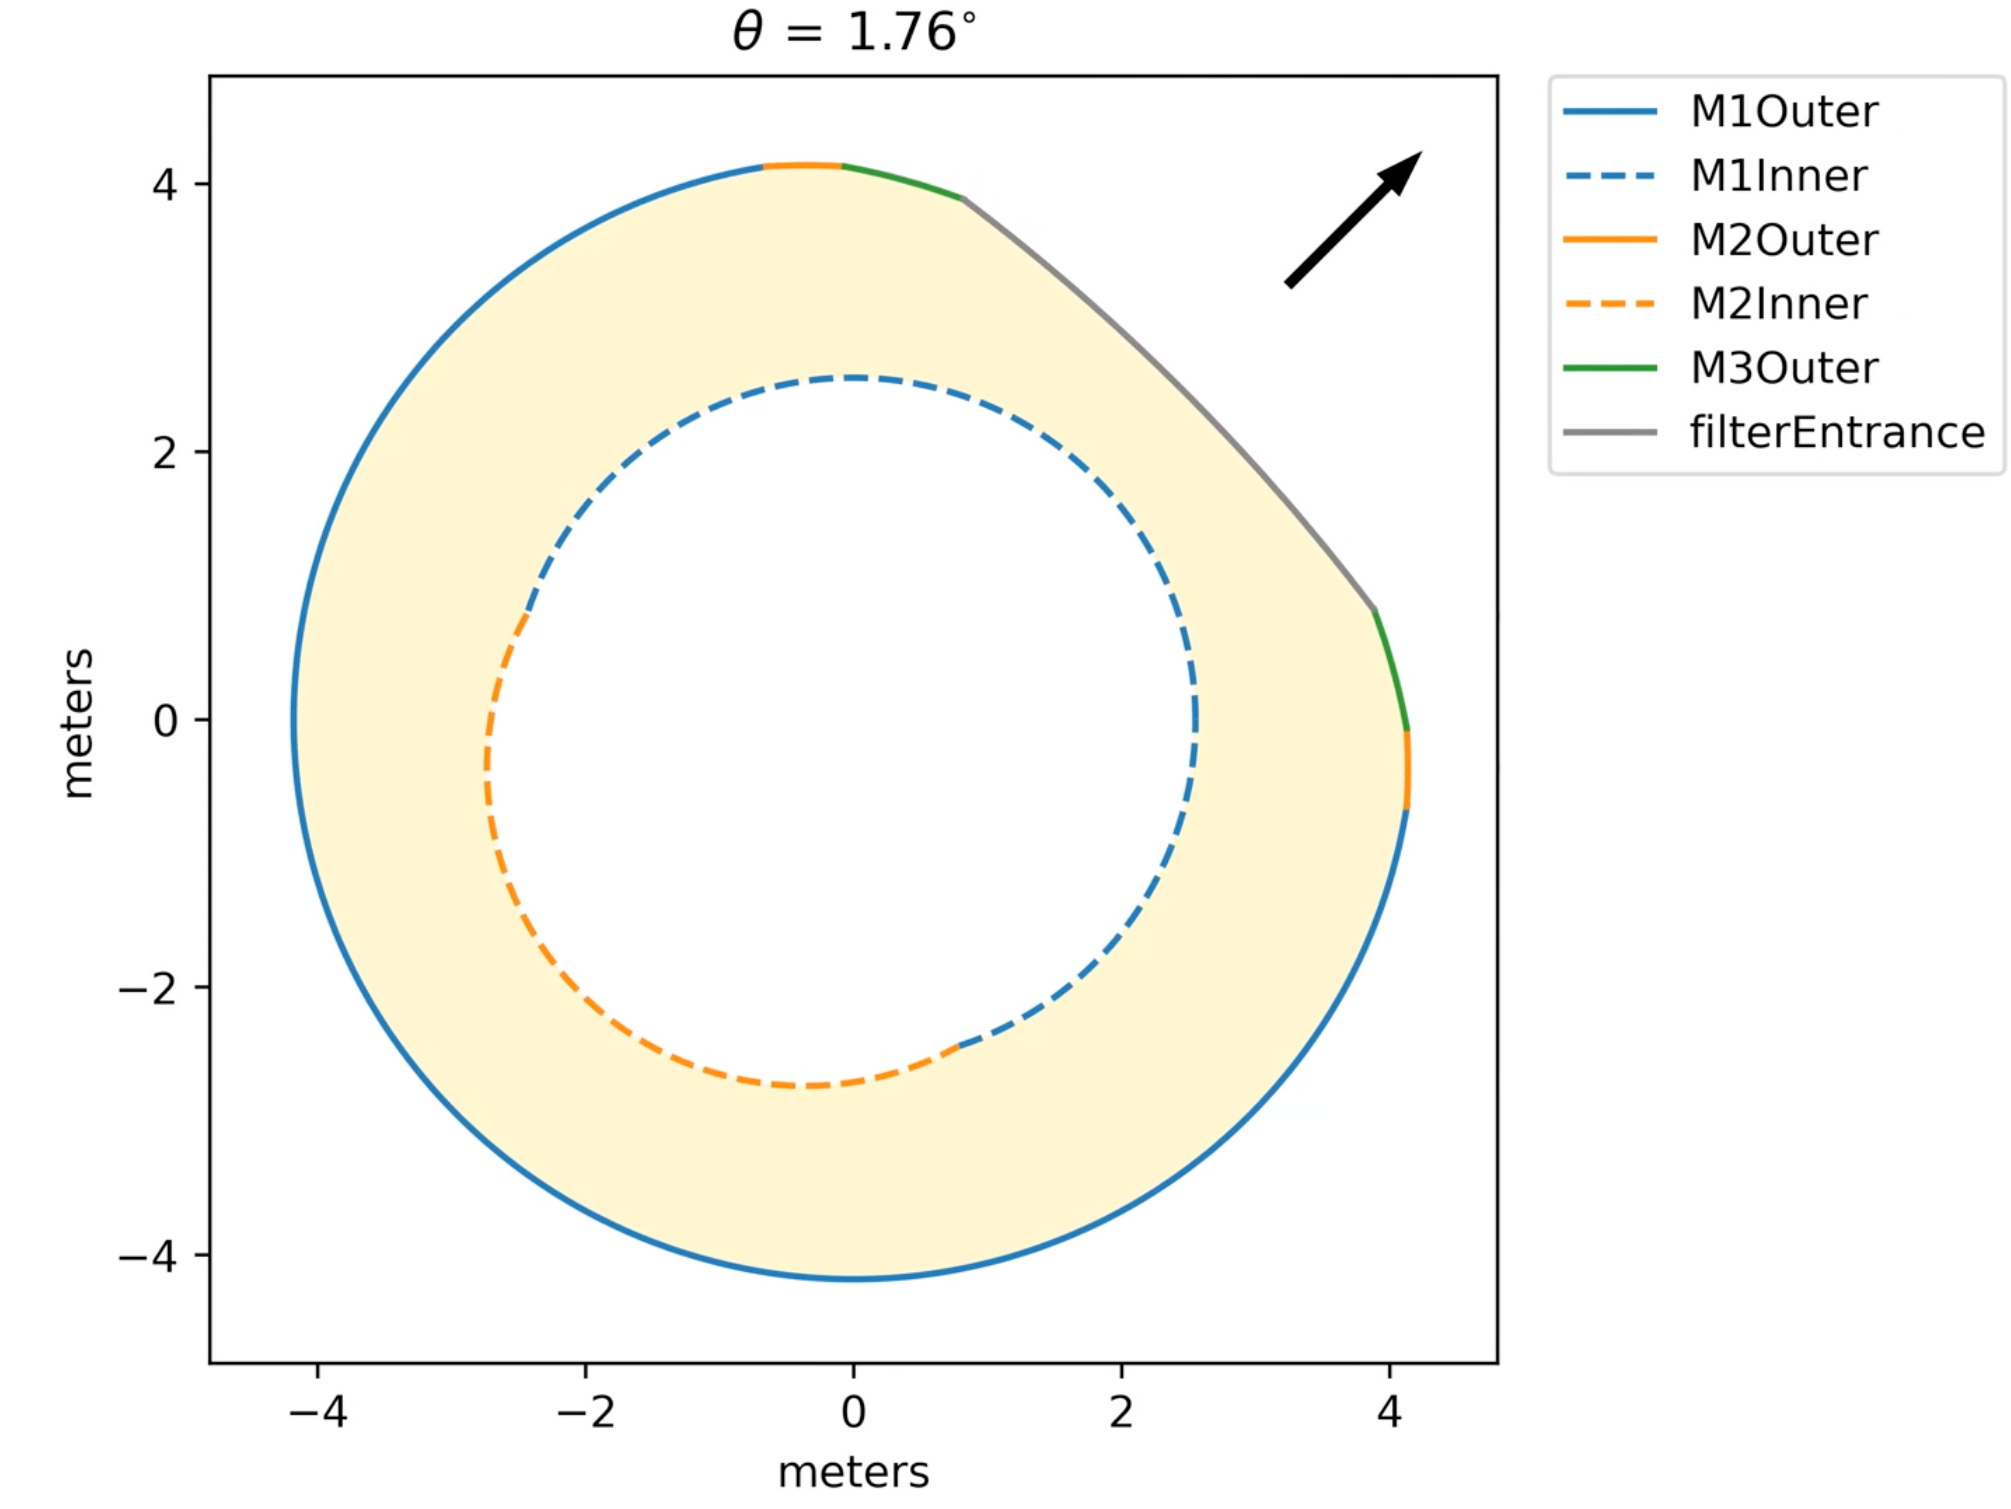

In [9]:
Image('mask_model_1.76.png')

## Zernike Estimation Performance with Vignetted Donuts

For the rest of the notebook we use a series of runs in which we take a single extra-focal donut always at the same location and a single intra-focal donut at a different distance from the center of the field and run the full closed loop simulation. 

In this section for each wavefront sensor pair we load the Zernike coefficients from the first iteration of the closed loop. We then compare these results with the OPD values to see how well we can reproduce the true values with varying levels of vignetting.

In [10]:
field_distances = []
for dir_name in os.listdir(supporting_data_folder):
    if dir_name == 'catalogs':
        continue
    field_dist = dir_name.split('_')[2]
    if field_dist == 'all':
        continue
    field_distances.append(field_dist)
field_distances.sort()

In [11]:
detectorZerns = {}
for extraId in extraDetectorIds:
    dataIdExtra = extraDataIds[str(extraId)]
    zernVals = []
    for field_dist in field_distances:
        # Repository with simulated data
        with open(os.path.join(f'{supporting_data_folder}/single_donut_{field_dist}/iter0/img/wfs.zer'), 'r') as f:
            wfs_truth = yaml.safe_load(f)
            wfs_str_list = wfs_truth[extraId]
            wfs_truth[extraId] = np.loadtxt(wfs_str_list)
            zernVals.append(wfs_truth[extraId])

    detectorZerns[str(extraId)] = zernVals

In [12]:
# Load the OPD "Truth" information
with  open(os.path.join(f'{supporting_data_folder}/single_donut_{field_dist}/iter0/img/opd.zer'), 'r') as f:
    opd_truth = yaml.safe_load(f)
for det_num in [191, 195, 199, 203]:
    opd_str_list = opd_truth[det_num]
    opd_truth[det_num] = np.loadtxt(opd_str_list)

In [13]:
camera = butler.get('camera', dataId={'instrument':'LSSTCam'}, collections='LSSTCam/calib/unbounded')

First, let's look at how the overall error in the wavefront estimate changes as a function of vignetting.

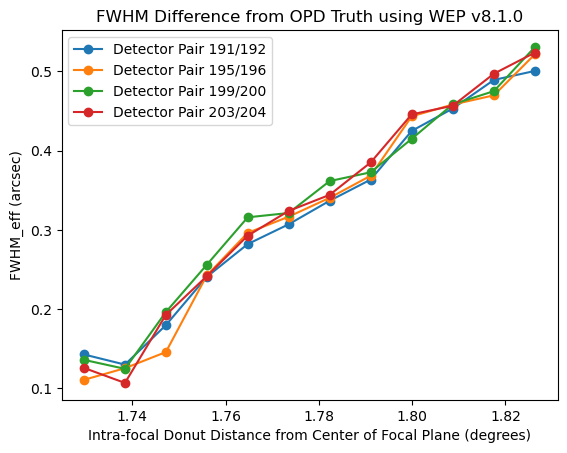

In [14]:
# Show zernikes on each sensor pair across different vignetting
i = 1
fig = plt.figure()
for extraId in extraDetectorIds:
    psfContrib = []
    for j in range(12):
        psfContrib.append(
            np.sqrt(np.sum(np.square(
                ConvertZernikesToPsfWidth(
                    detectorZerns[str(extraId)][j] - opd_truth[extraId]/1e3
                )
            )))
        )
    plt.plot(
        distToCenterVals, psfContrib, '-o', label=f'Detector Pair {extraId}/{extraId+1}'
    )
    i += 1
plt.ylabel('FWHM_eff (arcsec)')
plt.xlabel('Intra-focal Donut Distance from Center of Focal Plane (degrees)')
plt.title('FWHM Difference from OPD Truth using WEP v8.1.0')
plt.legend()

We see that there is a steady increase in the overall wavefront error as we move closer to the edge of the intra-focal sensor and vignetting increases.
This confirms that vignetting affects how well we can measure the Zernikes.


To learn more let's drill down into the errors in individual Zernike measurements as a function of distance from the center of the focal plane.

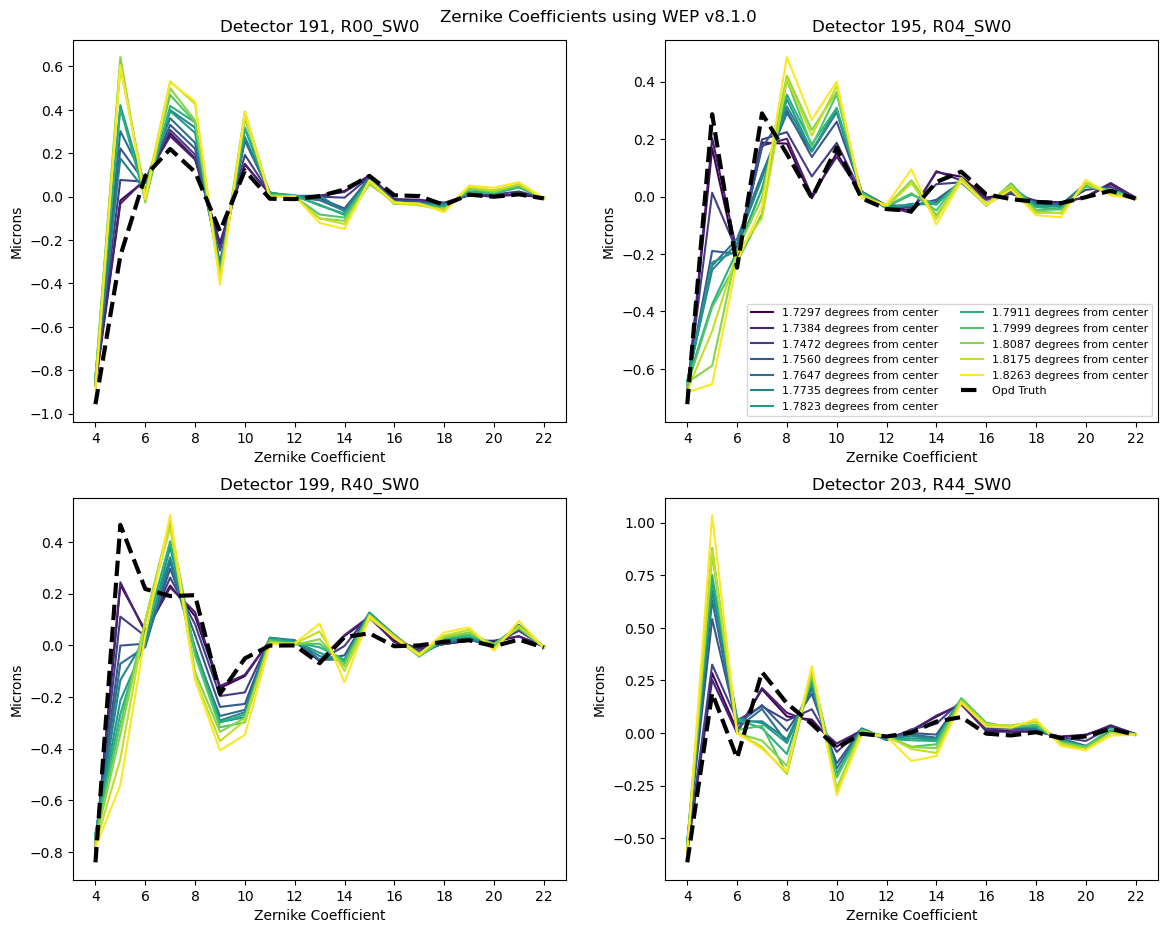

In [15]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))

n = len(distToCenterVals)
colors = plt.cm.viridis(np.linspace(0,1,n))

for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(12):
        plt.plot(np.arange(4, 23), detectorZerns[str(extraId)][j], label=f'{distToCenterVals[j]:.4f} degrees from center', c=colors[j])
    plt.plot(np.arange(4, 23), opd_truth[extraId]/1e3, '--', label=f'Opd Truth', lw=3, c='k')
    if i == 2:
        plt.legend(loc=4, ncol=2, fontsize=8)
    plt.title(f'Detector {extraId}, {camera[extraId].getName()}')
    plt.ylabel('Microns')
    plt.xlabel('Zernike Coefficient')
    plt.xticks(np.arange(4, 23, 2))
    i+=1
plt.suptitle('Zernike Coefficients using WEP v8.1.0')
plt.subplots_adjust(top=0.95)

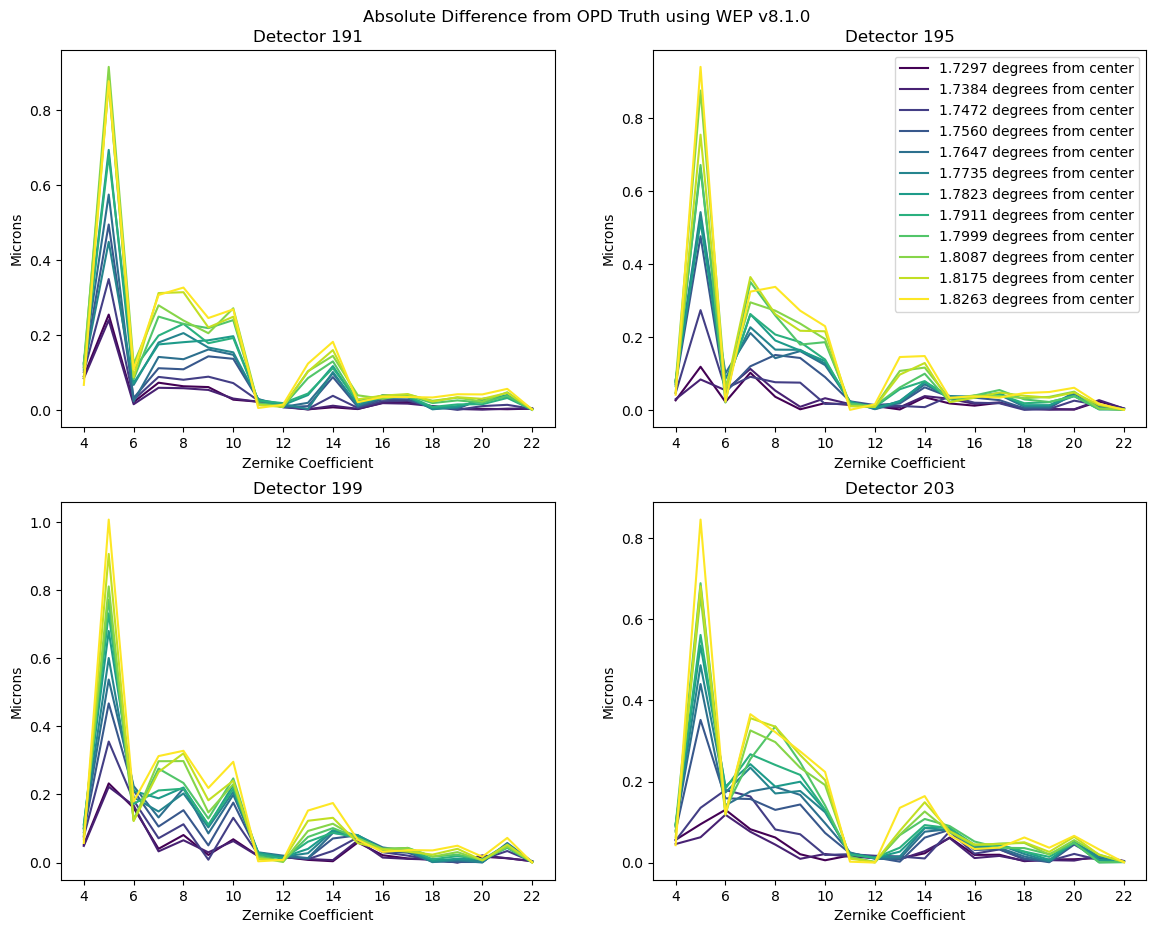

In [16]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))
for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(12):
        plt.plot(
            np.arange(4, 23), 
            np.abs(detectorZerns[str(extraId)][j]-opd_truth[extraId]/1e3), 
            label=f'{distToCenterVals[j]:.4f} degrees from center',
            c=colors[j]
        )
        plt.xticks(np.arange(4, 23, 2))
    if i == 2:
        plt.legend()
    plt.title(f'Detector {extraId}')
    plt.ylabel('Microns')
    plt.xlabel('Zernike Coefficient')
    i+=1
plt.suptitle('Absolute Difference from OPD Truth using WEP v8.1.0')
plt.subplots_adjust(top=0.94)

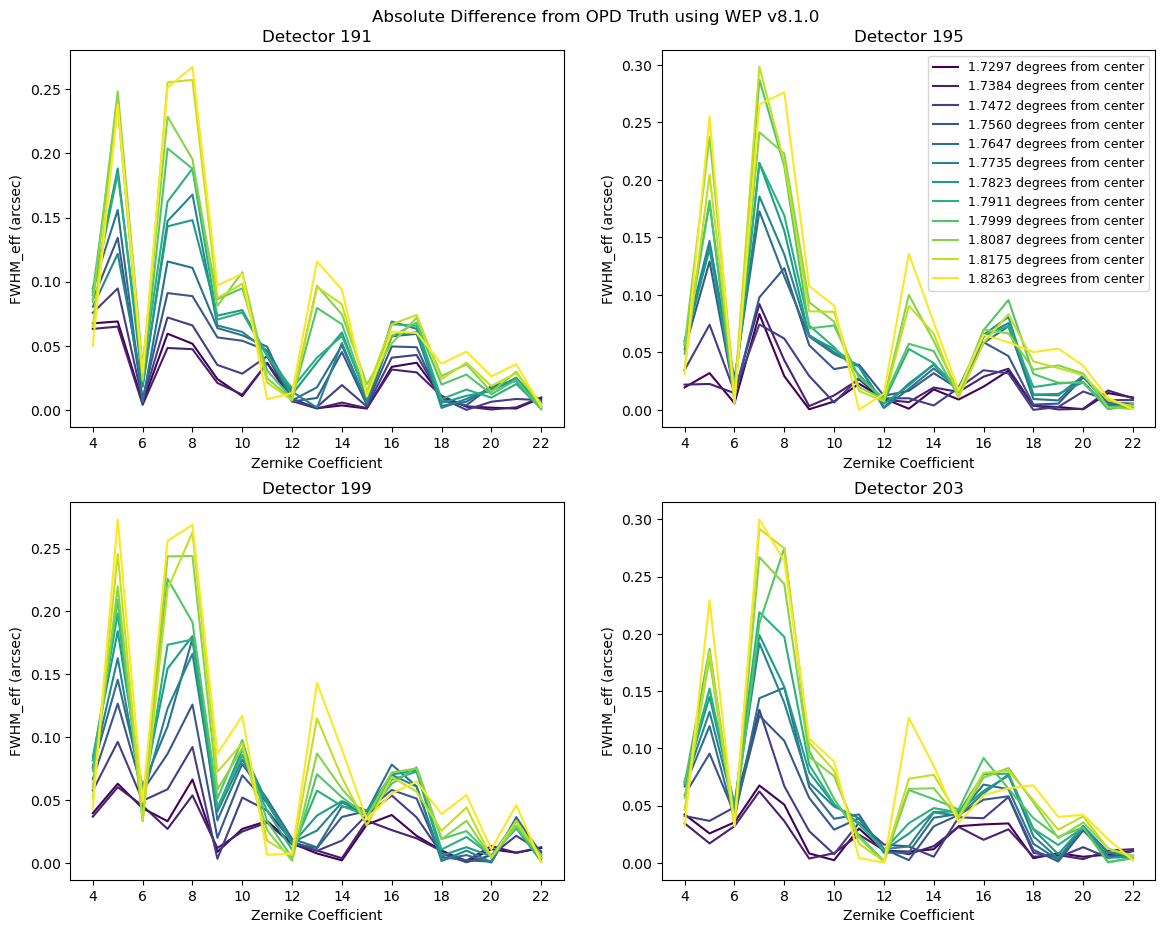

In [17]:
# Show zernikes on each sensor across different vignetting
i = 1
fig = plt.figure(figsize=(14, 10))
for extraId in extraDetectorIds:
    fig.add_subplot(2, 2, i)
    for j in range(12):
        plt.plot(
            np.arange(4, 23), 
            ConvertZernikesToPsfWidth(np.abs(detectorZerns[str(extraId)][j]-opd_truth[extraId]/1e3)), 
            label=f'{distToCenterVals[j]:.4f} degrees from center', 
            c=colors[j]
        )
        plt.xticks(np.arange(4, 23, 2))
    if i == 2:
        plt.legend(fontsize=9)
    plt.title(f'Detector {extraId}')
    plt.ylabel('FWHM_eff (arcsec)')
    plt.xlabel('Zernike Coefficient')
    i+=1
plt.suptitle('Absolute Difference from OPD Truth using WEP v8.1.0')
plt.subplots_adjust(top=0.94)

We can see that the WEP estimates get progressively worse compared to the OPD truth as we move to greater vignetting of the intra-focal donut. Looking at the differences in the individual Zernike measurements we see that for some Zernike modes (e.g., Z4, Z6, or Z11) the errors to the OPD are not dependent on the amount of vignetting. However, other Zernikes such as Z5, Z7, and Z8 have a strong negative effect that correlates with the amount of vignetting. Looking at the images of the Zernike polynomials below we can see this corresponds to Zernikes that primarily measure intensity along the diagonal direction. 

For instance let us compare the Zernike intensity maps below for Z5 and Z6. Z6 represents the amount of vertical astigmatism and measures defects parallel to the x and y axes but Z5 represents oblique astigmatism measures defects along the diagonal axis of the wavefront. At zero camera rotation relative to the mirrors, which we have in all of these closed loop simulations then the vignetting clips the donut along the oblique direction. As a result, this removes information that helps us calculate the true value of Z5 accurately leading to a detrioration in our measurement ability as this vignetting increases. This effect is exactly what we see in the plots above.

Thus, the question we next need to answer is how much vignetting can we accept before our ability to correct the wavefront is noticeably comprimised? 

In [18]:
Image(url='https://sitcomtn-003.lsst.io/_images/aZernikes.png')

## Closed loop results with vignetting

To answer this question we look in this section at the convergence of the AOS closed loop across a series of closed loop simulations where a single donut pair is used for each 10-iteration closed loop test. In each simulation the extra-focal donut remains the same but the paired intra-focal donut is simulated at a different distance from the center of the focal plane in each test. 

Using convergence of the closed loop as the determining factor we will try to define a limit for acceptable donuts based upon their distance from the center of the focal plane. In this section we look at the performance of the closed loop with varying amounts of vignetting.

### With background, `g_mag` = 14.0

In our tests all the stars are set to `g_mag` = 14.0 and we include sky background and atmospheric effects in the `imSim` simulations. We use the closed loop command and catalogs highlighted at the beginning of the notebook in the [Logistics](#Logistics) section.

In [19]:
field_distances = []
for dir_name in os.listdir(supporting_data_folder):
    if dir_name == 'catalogs':
        continue
    field_dist = dir_name.split('_')[2]
    if field_dist == 'all':
        continue
    field_distances.append(field_dist)
field_distances.sort()

In [20]:
PSSN_vals = {}
FWHM_vals = {}
for field_dist in field_distances:
    loop_PSSN = []
    for loop_iter in range(10):
        # PSSN files contain PSSN values and FWHM values for each iteration
        loop_PSSN.append(np.genfromtxt(os.path.join(f'{supporting_data_folder}/single_donut_{field_dist}/iter{loop_iter}/img/PSSN.txt')))
    PSSN_vals[field_dist] = np.array(loop_PSSN)[:, 0]
    FWHM_vals[field_dist] = np.array(loop_PSSN)[:, 1]

Text(0.5, 1.0, 'Closed Loop, 10 iterations, With Background, g=14.0')

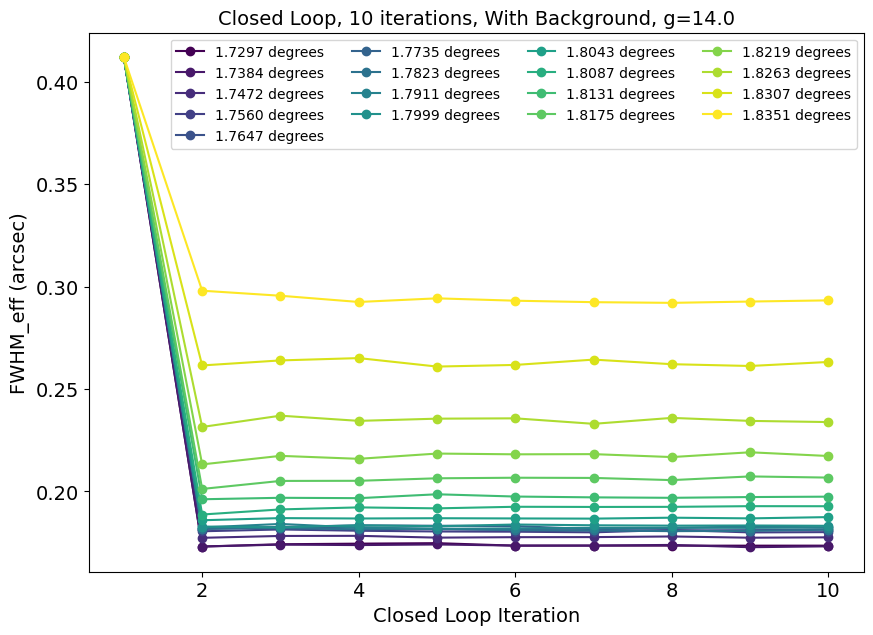

In [21]:
fig = plt.figure(figsize=(10, 7))

n = len(field_distances)
colors = plt.cm.viridis(np.linspace(0,1,n))

for idx, field_dist in enumerate(field_distances):
    plt.plot(
        np.arange(1, 11),
        FWHM_vals[field_dist][:, 4], 
        '-o', 
        label=f"{field_dist} degrees",
        c=colors[idx]
    )
plt.legend(fontsize=10, ncol=4)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Closed Loop, 10 iterations, With Background, g=14.0', size=14)

To get a better picture of the convergence values let's omit the first iteration with the initial, large perturbations and zoom in on iterations 2-10.

Text(0.5, 1.0, 'Closed Loop, Iterations 2-10, With Background, g=14.0')

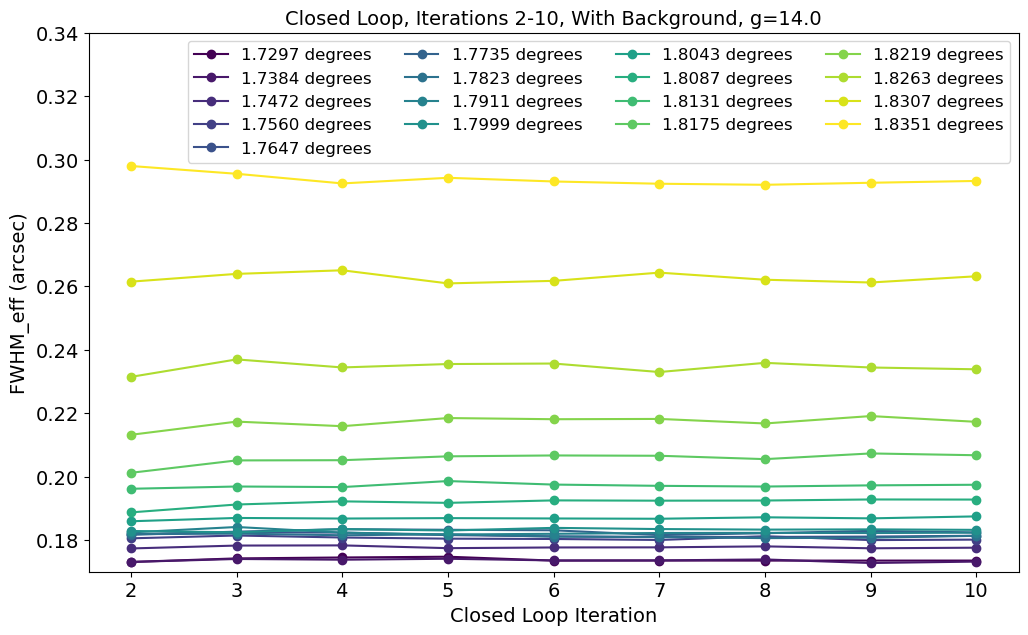

In [22]:
fig = plt.figure(figsize=(12, 7))
for idx, field_dist in enumerate(field_distances):
    plt.plot(
        np.arange(2, 11),
        FWHM_vals[field_dist][1:, 4], 
        '-o', 
        label=f"{field_dist} degrees",
        c=colors[idx]
    )
plt.legend(fontsize=12, ncol=4)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim((0.17, 0.34))
plt.title('Closed Loop, Iterations 2-10, With Background, g=14.0', size=14)

There seems to be a level of FWHM between 0.18 and 0.20 arcseconds where the convergence is steady as the intra-focal donut is simulated at varying distance but then the final FWHM value of convergence starts to rapidly deteriorate. To better find which distance from the focal plane marks the beginning of this deterioration let's zoom in on the range of FWHM convergence between 0.17 and 0.21 arcseconds.

Text(0.5, 1.0, 'Closed Loop, Iterations 2-10, With Background, g=14.0')

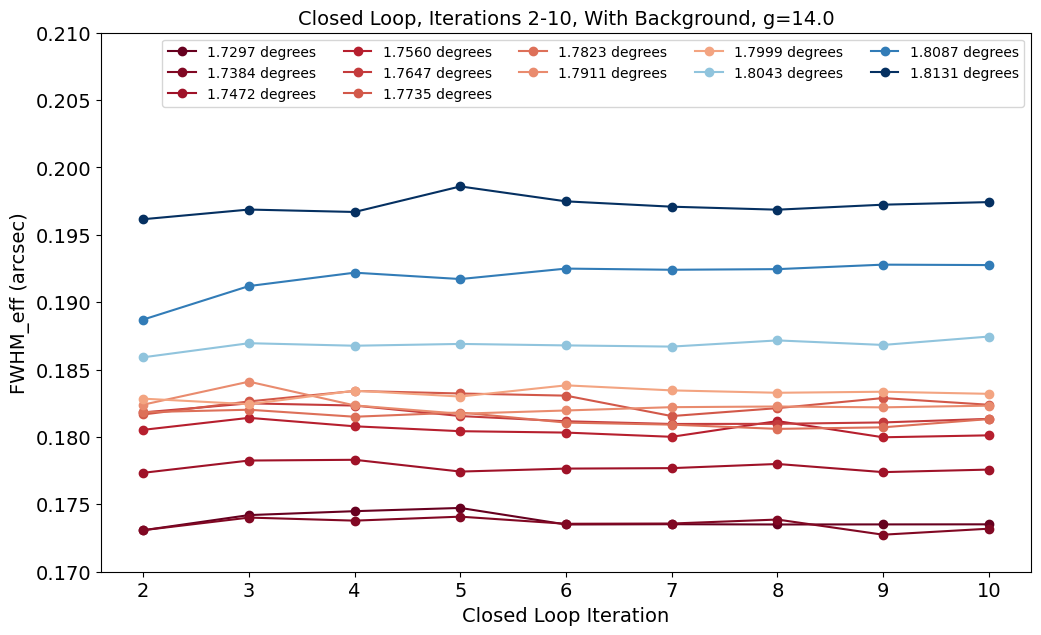

In [23]:
fig = plt.figure(figsize=(12, 7))

colors = plt.cm.RdBu(np.linspace(0, 0.3, 9))
colors = np.vstack([colors, plt.cm.RdBu(np.linspace(0.7, 1.0, 3))])

for idx, field_dist in enumerate(field_distances[:12]):
    plt.plot(
        np.arange(2, 11),
        FWHM_vals[field_dist][1:, 4], 
        '-o', 
        label=f"{field_dist} degrees",
        c=colors[idx]
    )
plt.legend(fontsize=10, ncol=5)
plt.xlabel('Closed Loop Iteration', size=14)
plt.ylabel('FWHM_eff (arcsec)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim((0.17, 0.21))
plt.title('Closed Loop, Iterations 2-10, With Background, g=14.0', size=14)

As we can see in the top two plots, all of the closed loop runs converge but there is a significant deterioration in the results at the highest level of vignetting.

In the final plot we zoom into iterations 2-10 and the range of FWHM convergence between 0.17 and 0.21 arcseconds. Here we see that there are a group of very similar results up to and including donuts at 1.7999 degrees from the center of the focal plane. After this point there seems to be a slight deterioration of the FWHM convergence of about 0.005 arcseconds each time we move out first to 1.8043 degrees then to progressively further distances. The highest amount of vignetting in our simulations at 1.8351 degrees from the center of the focal plane also converges but at around 0.30 arcsec which is more than 0.1 arcsec worse than the non-vignetted value.

Based upon these plots it seems that a conservative cut-off value that we should use going forward would be at 1.80 degrees from the center of the focal plane. It seems that beyond this point the vignetting starts to have a more noticeable effect on the final FWHM value at which the closed loop converges.

This 1.80 degree limit will be the default setting in the WEP pipeline as part of the DonutSelectorTask under the `maxFieldDist` configuration parameter ([code](https://github.com/lsst-ts/ts_wep/blob/e1c9b0489b2b4705771237b376aabedf6c46d515/python/lsst/ts/wep/task/donutSourceSelectorTask.py#L65-L69)). To set this to a different parameter when running the pipeline with a yaml configuration file this setting can be set like this:
```yaml
generateDonutCatalogWcsTask :
  class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
  config:
   donutSelector.maxFieldDist: 1.765 # Maximum distance from center of focal plane in degrees.
```

## Calculate area of detector cut off

Here we will calculate the distance each pixel in the intra-focal detector is from the center of the field and then calculate how many pixels are beyond the limit we will set for the AOS baseline pipeline at 1.8 degrees.

In [24]:
intraIm = butler.get('postISRCCD', dataId=intraDataIds[str(192)], collections=['ts_imsim_1000'])

In [25]:
# Create meshgrid for contours and calculate distance to center for points in grid
import lsst.geom
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE

X, Y = np.meshgrid(np.arange(0, 4096, 5), np.arange(0, 2001, 5))
Z = np.zeros(np.shape(X))

for x_idx in np.arange(0, 4096, 5):
    for y_idx in np.arange(0, 2001, 5):
        # Use detector object to convert between Pixels and Field Angle
        field_xy = intraIm.getDetector().transform(
            lsst.geom.Point2D(x_idx, y_idx), PIXELS, FIELD_ANGLE
        )
        field_dist = np.sqrt(field_xy[0]**2 + field_xy[1]**2)
        Z[int(y_idx/5), int(x_idx/5)] = np.degrees(field_dist)


Text(0, 0.5, 'Y Pixels')

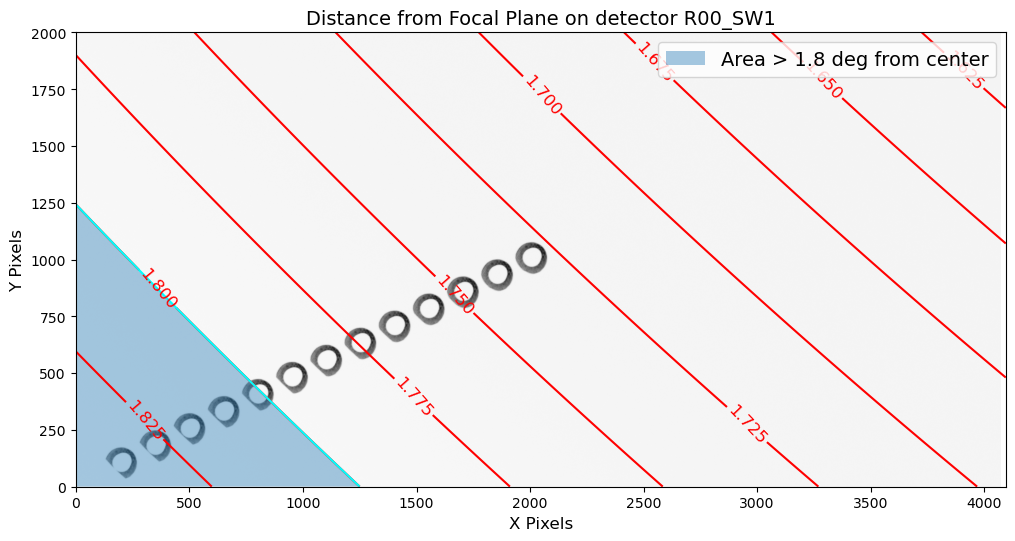

In [26]:
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
plt.imshow(intraIm.getImage().getArray(), cmap=plt.get_cmap('Greys'))
C = plt.contour(X, Y, Z, colors='red', levels=np.arange(1.60, 1.91, 0.025))
C1 = plt.contour(X, Y, Z, colors='cyan', levels=[1.80])
ax.clabel(C, inline=True, fontsize=12)
ax.fill_between(C1.allsegs[0][0][:,0], C1.allsegs[0][0][:,1], np.zeros(len(C1.allsegs[0][0])), alpha=0.4, label='Area > 1.8 deg from center')
plt.title(f'Distance from Focal Plane on detector {intraIm.getDetector().getName()}', size=14)
plt.legend(fontsize=14)
plt.xlabel('X Pixels', size=12)
plt.ylabel('Y Pixels', size=12)


In [27]:
frac_cutoff = len(np.where(Z > 1.80)[0])/(np.shape(Z)[0]*np.shape(Z)[1])

In [28]:
print(f"The amount of the detector cutoff is {frac_cutoff*100:.4f} percent for detector {intraIm.getDetector().getName()}.")

The amount of the detector cutoff is 9.3455 percent for detector R00_SW1.


Setting the limit of sources used in our baseline AOS pipeline still leaves us ~90.65% of the detector area. This seems acceptable and it does not look like we need to look at further vignetting algorithms but should focus our efforts on deblending to make sure we make the best use of the remaining 90.65% of the detector to get sources.

On the full focal plane this will affect some science detectors on the edge of the focal plane (~28 out of 189). In some cases this cutoff will affect these science detectors to a greater extent than the wavefront detectors. Looking at the plot below it seems that when running full focal plane tests it would be good to take note of this and avoid detectors such as `R43_S22` which has most of its observable area beyond our 1.8 degree limit for WEP.

Text(0, 0.5, 'Degrees')

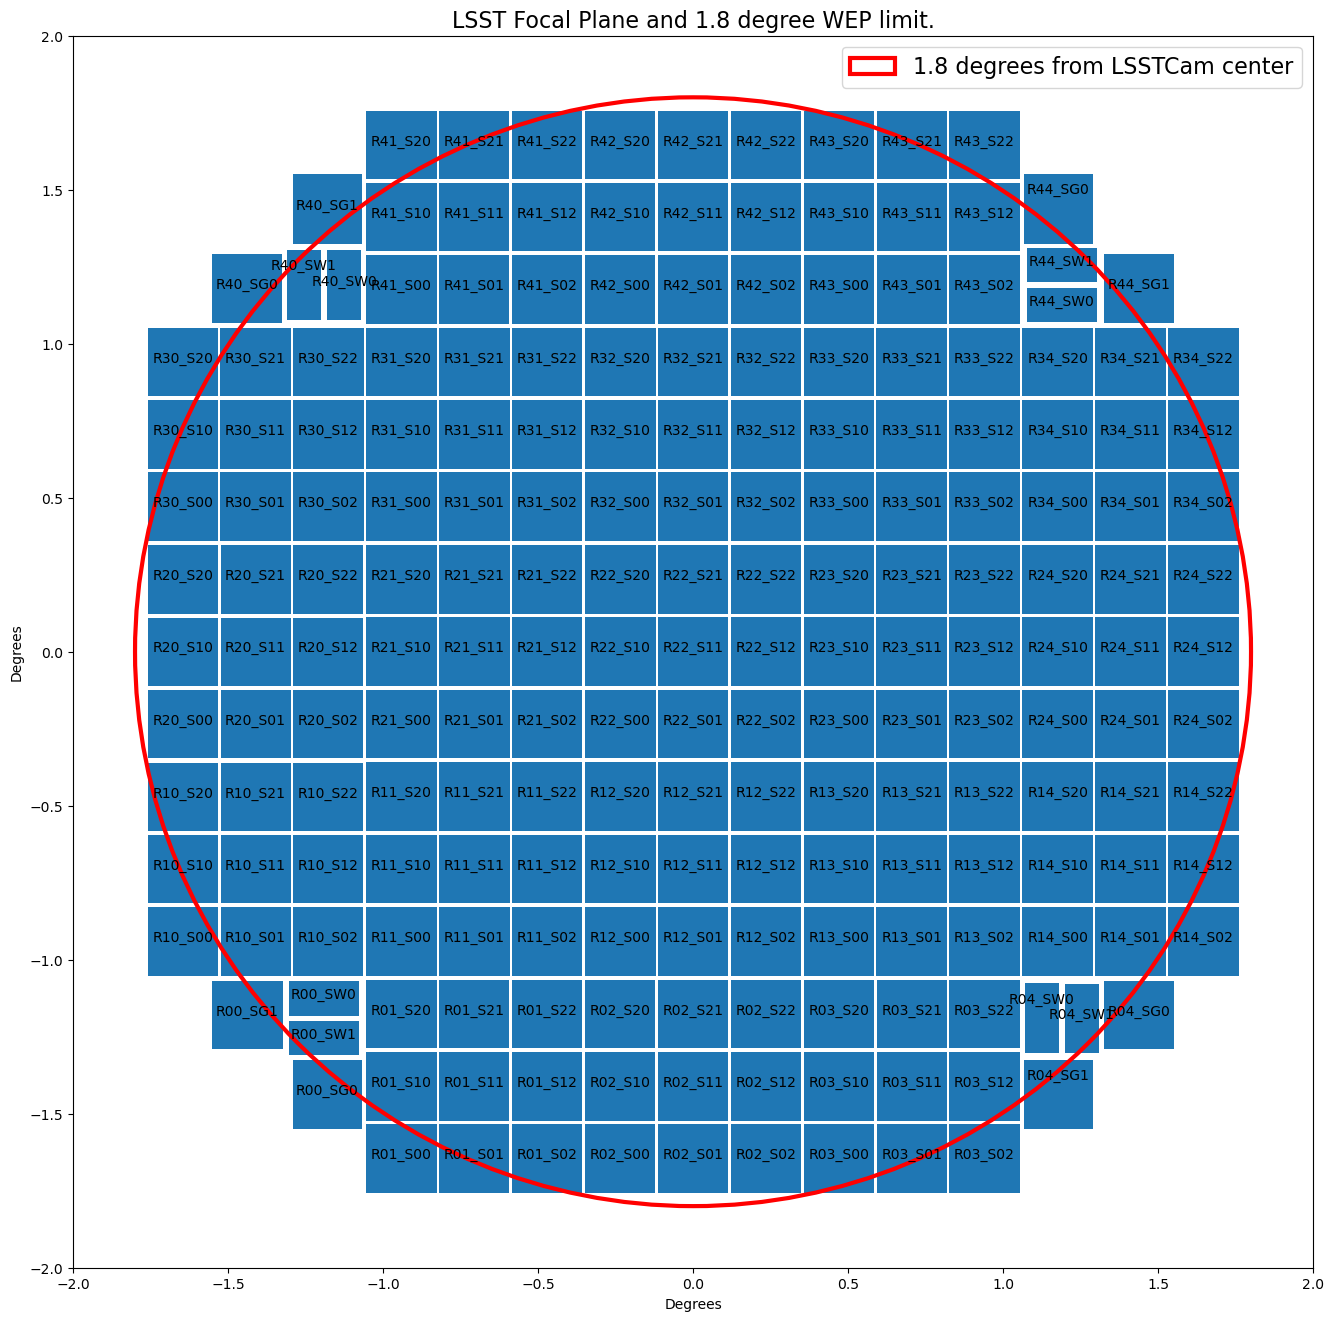

In [29]:
from matplotlib.patches import Rectangle, Circle
fig = plt.figure(figsize=(16,16))
for detector in camera:
    corners = detector.getCorners(FIELD_ANGLE)
    center = detector.getCenter(FIELD_ANGLE)
    centerX = np.degrees(center[0])
    centerY = np.degrees(center[1])
   
    ax = plt.gca()
    bbox = detector.getBBox()
    det_id = detector.getId()
    if det_id < 189:
        rect = Rectangle(np.degrees(corners[0]), bbox.getWidth()/5/3600, bbox.getHeight()/5/3600)
        plt.text(centerX, centerY, f'{detector.getName()}', ha='center')
    else:
        n_quarter = detector.getOrientation().getNQuarter()
        if n_quarter % 4 == 0:
            rect = Rectangle(np.degrees(corners[0]), bbox.getWidth()/5/3600, bbox.getHeight()/5/3600)
            plt.text(centerX, centerY, f'{detector.getName()}', ha='center')
        elif n_quarter % 4 == 1:
            rect = Rectangle(np.degrees(corners[3]), bbox.getHeight()/5/3600, bbox.getWidth()/5/3600)
            plt.text(centerX, centerY, f'{detector.getName()}', ha='center')
        elif n_quarter % 4 == 2:
            rect = Rectangle(np.degrees(corners[2]), bbox.getWidth()/5/3600, bbox.getHeight()/5/3600)
            plt.text(centerX, centerY, f'{detector.getName()}', ha='center')
        elif n_quarter % 4 == 3:
            plt.text(centerX, centerY+.05, f'{detector.getName()}', ha='center')
            rect = Rectangle(np.degrees(corners[1]), bbox.getHeight()/5/3600, bbox.getWidth()/5/3600)
    ax.add_patch(rect)

circle = Circle((0.0, 0.0), radius=1.8, fill=False, label='1.8 degrees from LSSTCam center', color='r', lw=3)
ax.add_patch(circle)
    
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend(fontsize=16)
plt.title('LSST Focal Plane and 1.8 degree WEP limit.', size=16)
plt.xlabel('Degrees')
plt.ylabel('Degrees')